In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# 1. Dataset Preparation
data_dir = r".\Datasets\kvasir-dataset-v2"

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the training dataset
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Get class names
class_names = train_dataset.classes
print(f"Class names: {class_names}")


Class names: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


In [3]:
# 2. Feature Extractor (Base Network)
def build_base_network():
    base_model = models.resnet18(pretrained=True)
    base_model.fc = nn.Identity()  # Remove the fully connected layer
    return base_model


In [4]:
# 3. Compute Class Prototypes
def compute_class_prototypes(train_loader, base_network, class_names):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    base_network.eval()
    base_network.to(device)

    embeddings = {class_name: [] for class_name in class_names}

    with torch.no_grad():
        for images, labels in tqdm(train_loader, desc="Computing Class Prototypes"):
            images, labels = images.to(device), labels.to(device)
            features = base_network(images)
            for i, label in enumerate(labels):
                class_name = class_names[label.item()]
                embeddings[class_name].append(features[i].cpu())

    class_prototypes = {class_name: torch.mean(torch.stack(embeddings[class_name]), dim=0)
                        for class_name in class_names}
    return class_prototypes


In [5]:
# 4. Siamese Neural Network Definition
class SiameseNetwork(nn.Module):
    def __init__(self, base_network):
        super(SiameseNetwork, self).__init__()
        self.base_network = base_network
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        img1, prototype = inputs  # img1 is a batch of images, prototype is 1D or expanded
        feature1 = self.base_network(img1)  # Extract features from batch of images
        distance = torch.abs(feature1 - prototype)  # Calculate absolute difference
        similarity = self.fc(distance)  # Calculate similarity
        return similarity


In [6]:
def train_snn_classification(model, train_loader, class_prototypes, class_names, epochs=10, save_path="snn_model.pth"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            batch_size = images.size(0)
            scores = torch.zeros(batch_size, len(class_names)).to(device)

            # Compute similarity scores with all class prototypes
            for i, class_name in enumerate(class_names):
                prototype = class_prototypes[class_name].to(device)
                similarities = model([images, prototype.expand(batch_size, -1)])
                scores[:, i] = similarities.squeeze()

            # Compute loss and backpropagate
            loss = criterion(scores, labels)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")

    # Ensure save path directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    return model

In [7]:
# 6. Inference Function
def classify_image_snn(image_path, model, class_prototypes, class_names):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(image_path).convert('RGB')
    input_img = transform(img).unsqueeze(0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_img = input_img.to(device)
    model = model.to(device)

    similarity_scores = {}
    with torch.no_grad():
        for class_name, prototype in class_prototypes.items():
            prototype = prototype.unsqueeze(0).to(device)
            similarity = model([input_img, prototype])
            similarity_scores[class_name] = similarity.item()

    predicted_class = max(similarity_scores, key=similarity_scores.get)
    print(f"Similarity scores: {similarity_scores}")
    print(f"Predicted Class: {predicted_class}")

    plt.imshow(np.array(img))
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class


G:\anaconda3\envs\Florence\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
G:\anaconda3\envs\Florence\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Computing class prototypes...


Computing Class Prototypes: 100%|████████████████████████████████████████████████████| 250/250 [03:25<00:00,  1.22it/s]


Class prototypes saved.
Training the Siamese Network...
Epoch 1/10, Loss: 1.499543909072876
Epoch 2/10, Loss: 1.4316529746055604
Epoch 3/10, Loss: 1.4221002550125121
Epoch 4/10, Loss: 1.4113187232017517
Epoch 5/10, Loss: 1.405907500743866
Epoch 6/10, Loss: 1.4072351937294005
Epoch 7/10, Loss: 1.4015930142402648
Epoch 8/10, Loss: 1.4015032558441163
Epoch 9/10, Loss: 1.3992354793548585
Epoch 10/10, Loss: 1.398736515522003
Model saved to ./models/snn_model.pth
Performing inference...
Similarity scores: {'dyed-lifted-polyps': 2.8190286910367846e-11, 'dyed-resection-margins': 1.2155206841057975e-09, 'esophagitis': 5.813232117901634e-09, 'normal-cecum': 2.6476894010585283e-09, 'normal-pylorus': 3.4334182632406174e-12, 'normal-z-line': 3.337045570428465e-11, 'polyps': 2.501289619871727e-09, 'ulcerative-colitis': 0.9999996423721313}
Predicted Class: ulcerative-colitis


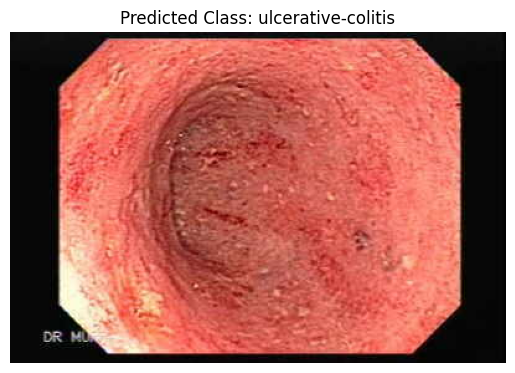

The predicted class is: ulcerative-colitis


In [8]:
if __name__ == "__main__":
    # Build the base network
    base_network = build_base_network()

    # Compute class prototypes
    print("Computing class prototypes...")
    class_prototypes = compute_class_prototypes(train_loader, base_network, class_names)

    # Save the prototypes
    torch.save(class_prototypes, "class_prototypes.pth")
    print("Class prototypes saved.")

    # Initialize and train the Siamese Network
    siamese_model = SiameseNetwork(base_network)
    print("Training the Siamese Network...")
    trained_model = train_snn_classification(
        siamese_model, 
        train_loader, 
        class_prototypes, 
        class_names, 
        epochs=10, 
        save_path="./models/snn_model.pth"
    )

    # Perform inference
    print("Performing inference...")
    test_image_path = "./Datasets/Samples/sample1.jpg"  
    predicted_class = classify_image_snn(test_image_path, trained_model, class_prototypes, class_names)
    print(f"The predicted class is: {predicted_class}")

Similarity scores: {'dyed-lifted-polyps': 1.4327980468742396e-10, 'dyed-resection-margins': 2.0953019319591704e-09, 'esophagitis': 0.9999984502792358, 'normal-cecum': 8.004269075074111e-15, 'normal-pylorus': 8.262824452431872e-12, 'normal-z-line': 0.9999992847442627, 'polyps': 1.775795222674903e-13, 'ulcerative-colitis': 1.6062270871003426e-12}
Predicted Class: normal-z-line


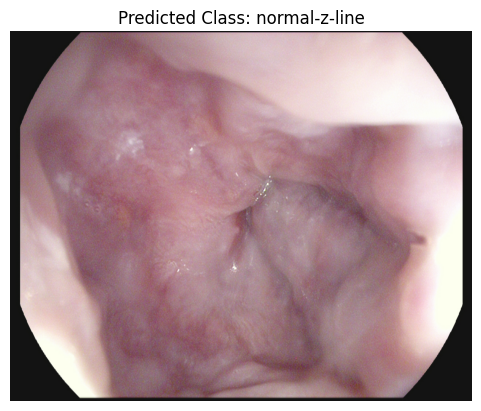

The predicted class is: normal-z-line


In [9]:
test_image_path = "./Datasets/Samples/sample2.jpg" 
predicted_class = classify_image_snn(test_image_path, siamese_model, class_prototypes, class_names)
print(f"The predicted class is: {predicted_class}")

Similarity scores: {'dyed-lifted-polyps': 3.768241867874167e-06, 'dyed-resection-margins': 2.042265023760592e-08, 'esophagitis': 2.6038853365162318e-11, 'normal-cecum': 0.0005658018053509295, 'normal-pylorus': 6.064318491816323e-10, 'normal-z-line': 3.22861702650723e-12, 'polyps': 0.9999734163284302, 'ulcerative-colitis': 0.998776376247406}
Predicted Class: polyps


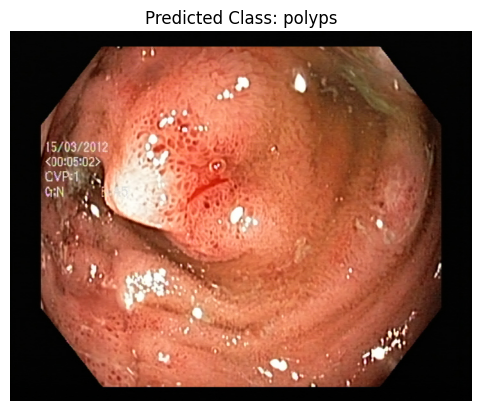

The predicted class is: polyps


In [10]:
test_image_path = "./Datasets/Samples/polyp-sample.jpg" 
predicted_class = classify_image_snn(test_image_path, siamese_model, class_prototypes, class_names)
print(f"The predicted class is: {predicted_class}")

Similarity scores: {'dyed-lifted-polyps': 1.0, 'dyed-resection-margins': 1.0, 'esophagitis': 1.453352852832674e-14, 'normal-cecum': 1.5533860005592648e-12, 'normal-pylorus': 3.4948444407836463e-16, 'normal-z-line': 1.1369719015829737e-15, 'polyps': 8.297668802059732e-11, 'ulcerative-colitis': 4.2163997987509916e-12}
Predicted Class: dyed-lifted-polyps


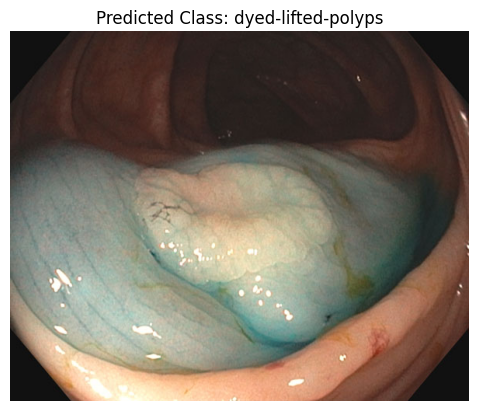

The predicted class is: dyed-lifted-polyps


In [11]:
test_image_path = "./Datasets/Samples/dyed-lifted-polyp-sample.jpg" 
predicted_class = classify_image_snn(test_image_path, siamese_model, class_prototypes, class_names)
print(f"The predicted class is: {predicted_class}")